Name: Minh Phan

Library: Selenium 

URL: [https://www.selenium.dev/](https://www.selenium.dev/)

Description: 
This library is an open-source automation framework that provides a programming interface for controlling web browsers. Originally developed in 2004 by Jason Huggins at ThoughtWorks for automated testing, Selenium has evolved into the industry standard for browser automation and has become an indispensable tool for data scientists, QA engineers, and automation specialists worldwide.

In [19]:
# Import required libraries
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from selenium.common.exceptions import TimeoutException, NoSuchElementException
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
from datetime import datetime
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import warnings
import atexit
import signal
import sys
import os
import sys
import gc

warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)




In [5]:
# CELL 2: Initialize Chrome WebDriver with Configuration
# ============================================================================
"""
Set up Chrome WebDriver with anti-detection features and optimal settings
"""
def initialize_driver(headless=False, wait_time=15):
    """Initialize Chrome WebDriver with custom options"""
    
    # Configure Chrome options
    chrome_options = webdriver.ChromeOptions()
    
    if headless:
        chrome_options.add_argument('--headless=new')
    
    # Anti-detection and performance settings
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument('--disable-blink-features=AutomationControlled')
    chrome_options.add_argument('--window-size=1920,1080')
    chrome_options.add_argument(
        'user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
        'AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'
    )
    
    # Initialize driver with automatic driver management
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=chrome_options)
    wait = WebDriverWait(driver, wait_time)
    
    print(f"✓ Chrome WebDriver initialized")
    print(f"✓ Browser version: {driver.capabilities['browserVersion']}")
    
    return driver, wait

# Initialize the driver (set headless=True to run without GUI)
driver, wait = initialize_driver(headless=False, wait_time=15)

✓ Chrome WebDriver initialized
✓ Browser version: 141.0.7390.123


In [6]:
# CELL 3: Helper Functions - Random Delays and Scrolling
# ============================================================================
"""
Utility functions to mimic human behavior and handle dynamic content
"""
def random_delay(min_seconds=2, max_seconds=4):
    """Add random delay to avoid detection"""
    delay = random.uniform(min_seconds, max_seconds)
    time.sleep(delay)
    print(f"Waited {delay:.2f} seconds")

def scroll_page(driver):
    """Scroll page to trigger lazy-loaded content"""
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(1)
    driver.execute_script("window.scrollTo(0, 0);")
    time.sleep(0.5)
    print("  ↕ Page scrolled")

# Test the functions
print("Testing helper functions:")
random_delay(1, 2)
print("Helper functions ready")


Testing helper functions:
Waited 1.92 seconds
Helper functions ready


In [7]:
# CELL 4: Safe Element Finding Function
# ============================================================================
"""
Robust element finding with error handling and custom timeouts
"""
def safe_find_element(driver, by, value, timeout=None, scroll=False):
    """
    Safely find an element with proper error handling
    
    Args:
        driver: Selenium WebDriver instance
        by: Selenium By locator strategy (e.g., By.CSS_SELECTOR)
        value: Locator value
        timeout: Optional custom timeout
        scroll: Whether to scroll before finding element
        
    Returns:
        WebElement or None if not found
    """
    try:
        if scroll:
            scroll_page(driver)
        
        if timeout:
            element = WebDriverWait(driver, timeout).until(
                EC.presence_of_element_located((by, value))
            )
        else:
            element = driver.find_element(by, value)
        
        print(f"Found element: {value}")
        return element
    
    except (TimeoutException, NoSuchElementException) as e:
        print(f"  Element not found: {value}")
        return None

print("Safe element finder ready")

Safe element finder ready


In [8]:
# CELL 5: Wait for Table Loading Function
# ============================================================================
"""
Wait for dynamic tables to fully load before scraping
"""
def wait_for_table_load(driver, timeout=20):
    """
    Wait for table to fully load on F1 website
    
    Args:
        driver: Selenium WebDriver instance
        timeout: Maximum wait time in seconds
        
    Returns:
        bool: True if table loaded successfully
    """
    try:
        # Wait for table body to be present and populated
        WebDriverWait(driver, timeout).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "table tbody tr"))
        )
        time.sleep(2)  # Additional wait for JavaScript rendering
        print(" Table loaded successfully")
        return True
    
    except TimeoutException:
        print(" Timeout waiting for table to load")
        return False

print(" Table loading function ready")

 Table loading function ready


## Now we done with setting up all the functions to help us grab the data, let't bring them into actions using F1 season 2024 data from its offiical webiste

In [9]:
 #CELL 6: Scrape Race Results Function
# ============================================================================
"""
Main function to scrape race results from F1 website
"""
def scrape_race_results(driver, year=2024):
    """
    Scrape race results for a specific F1 season
    
    Args:
        driver: Selenium WebDriver instance
        year: F1 season year
        
    Returns:
        pd.DataFrame: Race results data
    """
    print(f"\n{'='*60}")
    print(f"Scraping race results for {year} season...")
    print(f"{'='*60}")
    
    base_url = "https://www.formula1.com"
    race_results = []
    
    try:
        # Navigate to results page
        url = f"{base_url}/en/results/{year}/races"
        print(f"   Navigating to: {url}")
        driver.get(url)
        random_delay(3, 5)
        
        # Scroll to load content
        scroll_page(driver)
        
        # Wait for table to load
        if not wait_for_table_load(driver):
            print("   Could not load race results table")
            return pd.DataFrame()
        
        # Find table using multiple selectors
        table = None
        selectors = [
            "table",
            "table.f1-table",
            "div.resultsarchive-table table",
            ".race-result-table"
        ]
        
        for selector in selectors:
            try:
                table = driver.find_element(By.CSS_SELECTOR, selector)
                if table:
                    print(f"   Found table using selector: {selector}")
                    break
            except NoSuchElementException:
                continue
        
        if not table:
            print("   Could not find results table")
            return pd.DataFrame()
        
        # Extract table rows
        rows = table.find_elements(By.TAG_NAME, "tr")
        print(f"  → Found {len(rows)} rows in table")
        
        # Extract headers
        header_cells = rows[0].find_elements(By.TAG_NAME, "th")
        if not header_cells:
            header_cells = rows[0].find_elements(By.TAG_NAME, "td")
        
        headers = [cell.text.strip() for cell in header_cells]
        print(f"  Headers: {headers}")
        
        # Extract data rows
        for idx, row in enumerate(rows[1:], 1):
            try:
                cells = row.find_elements(By.TAG_NAME, "td")
                if len(cells) >= 4:
                    cell_data = [cell.text.strip() for cell in cells]
                    
                    race_data = {
                        'year': year,
                        'grand_prix': cell_data[0] if len(cell_data) > 0 else None,
                        'date': cell_data[1] if len(cell_data) > 1 else None,
                        'winner': cell_data[2] if len(cell_data) > 2 else None,
                        'car': cell_data[3] if len(cell_data) > 3 else None,
                        'laps': cell_data[4] if len(cell_data) > 4 else None,
                        'time': cell_data[5] if len(cell_data) > 5 else None,
                        'scraped_at': datetime.now().isoformat()
                    }
                    
                    if race_data['winner'] and race_data['winner'] != '':
                        race_results.append(race_data)
                        print(f"  {idx}. {race_data['grand_prix']} - {race_data['winner']}")
                        
            except Exception as e:
                print(f"   Error parsing row {idx}: {e}")
                continue

        print(f"  Successfully scraped {len(race_results)} race results")
        return pd.DataFrame(race_results)
        
    except Exception as e:
        print(f"   Error scraping race results: {e}")
        import traceback
        traceback.print_exc()
        return pd.DataFrame()

print("Race results scraper ready")



Race results scraper ready


In [10]:
race_results = scrape_race_results(driver, year=2024)
race_results 


Scraping race results for 2024 season...
   Navigating to: https://www.formula1.com/en/results/2024/races
Waited 3.39 seconds
  ↕ Page scrolled
 Table loaded successfully
   Found table using selector: table
  → Found 25 rows in table
  Headers: ['GRAND PRIX', 'DATE', 'WINNER', 'TEAM', 'LAPS', 'TIME']
  1. Bahrain - Max Verstappen
  2. Saudi Arabia - Max Verstappen
  3. Australia - Carlos Sainz
  4. Japan - Max Verstappen
  5. China - Max Verstappen
  6. Miami - Lando Norris
  7. Emilia-Romagna - Max Verstappen
  8. Monaco - Charles Leclerc
  9. Canada - Max Verstappen
  10. Spain - Max Verstappen
  11. Austria - George Russell
  12. Great Britain - Lewis Hamilton
  13. Hungary - Oscar Piastri
  14. Belgium - Lewis Hamilton
  15. Netherlands - Lando Norris
  16. Italy - Charles Leclerc
  17. Azerbaijan - Oscar Piastri
  18. Singapore - Lando Norris
  19. United States - Charles Leclerc
  20. Mexico - Carlos Sainz
  21. Brazil - Max Verstappen
  22. Las Vegas - George Russell
  23. Qat

,year,grand_prix,date,winner,car,laps,time,scraped_at
0,2024,Bahrain,02 Mar,Max Verstappen,Red Bull Racing Honda RBPT,57,1:31:44.742,2025-11-03T13:30:04.752578
1,2024,Saudi Arabia,09 Mar,Max Verstappen,Red Bull Racing Honda RBPT,50,1:20:43.273,2025-11-03T13:30:04.780558
2,2024,Australia,24 Mar,Carlos Sainz,Ferrari,58,1:20:26.843,2025-11-03T13:30:04.810553
3,2024,Japan,07 Apr,Max Verstappen,Red Bull Racing Honda RBPT,53,1:54:23.566,2025-11-03T13:30:04.838729
4,2024,China,21 Apr,Max Verstappen,Red Bull Racing Honda RBPT,56,1:40:52.554,2025-11-03T13:30:04.870657
5,2024,Miami,05 May,Lando Norris,McLaren Mercedes,57,1:30:49.876,2025-11-03T13:30:04.903331
6,2024,Emilia-Romagna,19 May,Max Verstappen,Red Bull Racing Honda RBPT,63,1:25:25.252,2025-11-03T13:30:04.945545
7,2024,Monaco,26 May,Charles Leclerc,Ferrari,78,2:23:15.554,2025-11-03T13:30:04.975803
8,2024,Canada,09 Jun,Max Verstappen,Red Bull Racing Honda RBPT,70,1:45:47.927,2025-11-03T13:30:05.008190
9,2024,Spain,23 Jun,Max Verstappen,Red Bull Racing Honda RBPT,66,1:28:20.227,2025-11-03T13:30:05.040785


In [11]:
# CELL 7: Scrape Driver Standings Function
# ============================================================================
"""
Function to scrape driver championship standings
"""
def scrape_driver_standings(driver, year=2024):
    """
    Scrape driver championship standings for a specific season
    
    Args:
        driver: Selenium WebDriver instance
        year: F1 season year
        
    Returns:
        pd.DataFrame: Driver standings data
    """
    print(f"\n{'='*60}")
    print(f"Scraping driver standings for {year}...")
    print(f"{'='*60}")
    
    base_url = "https://www.formula1.com"
    driver_standings = []
    
    try:
        url = f"{base_url}/en/results/{year}/drivers"
        print(f"  → Navigating to: {url}")
        driver.get(url)
        random_delay(3, 5)
        
        scroll_page(driver)
        if not wait_for_table_load(driver):
            return pd.DataFrame()
        
        table = driver.find_element(By.CSS_SELECTOR, "table")
        rows = table.find_elements(By.TAG_NAME, "tr")
        print(f"  → Found {len(rows)} rows")
        
        for idx, row in enumerate(rows[1:], 1):
            try:
                cells = row.find_elements(By.TAG_NAME, "td")
                if len(cells) >= 4:
                    cell_data = [cell.text.strip() for cell in cells]
                    
                    driver_data = {
                        'year': year,
                        'position': cell_data[0] if len(cell_data) > 0 else None,
                        'driver': cell_data[1] if len(cell_data) > 1 else None,
                        'nationality': cell_data[2] if len(cell_data) > 2 else None,
                        'car': cell_data[3] if len(cell_data) > 3 else None,
                        'points': cell_data[4] if len(cell_data) > 4 else '0',
                        'scraped_at': datetime.now().isoformat()
                    }
                    
                    try:
                        driver_data['points'] = float(driver_data['points'])
                    except:
                        driver_data['points'] = 0.0
                    
                    if driver_data['driver'] and driver_data['driver'] != '':
                        driver_standings.append(driver_data)
                        print(f"  {driver_data['position']}. {driver_data['driver']} - {driver_data['points']} pts")
                        
            except Exception as e:
                print(f"  ⚠ Error parsing row {idx}: {e}")
                continue
        
        print(f"\n Successfully scraped {len(driver_standings)} driver standings")
        return pd.DataFrame(driver_standings)
        
    except Exception as e:
        print(f" Error scraping driver standings: {e}")
        import traceback
        traceback.print_exc()
        return pd.DataFrame()


In [12]:
# Compute and display the driver standings for 2024 using the existing driver and function
driver_standings = scrape_driver_standings(driver, year=2024)
driver_standings


Scraping driver standings for 2024...
  → Navigating to: https://www.formula1.com/en/results/2024/drivers
Waited 3.95 seconds
  ↕ Page scrolled
 Table loaded successfully
  → Found 25 rows
  1. Max Verstappen - 437.0 pts
  2. Lando Norris - 374.0 pts
  3. Charles Leclerc - 356.0 pts
  4. Oscar Piastri - 292.0 pts
  5. Carlos Sainz - 290.0 pts
  6. George Russell - 245.0 pts
  7. Lewis Hamilton - 223.0 pts
  8. Sergio Perez - 152.0 pts
  9. Fernando Alonso - 70.0 pts
  10. Pierre Gasly - 42.0 pts
  11. Nico Hulkenberg - 41.0 pts
  12. Yuki Tsunoda - 30.0 pts
  13. Lance Stroll - 24.0 pts
  14. Esteban Ocon - 23.0 pts
  15. Kevin Magnussen - 16.0 pts
  16. Alexander Albon - 12.0 pts
  17. Daniel Ricciardo - 12.0 pts
  18. Oliver Bearman - 7.0 pts
  19. Franco Colapinto - 5.0 pts
  20. Zhou Guanyu - 4.0 pts
  21. Liam Lawson - 4.0 pts
  22. Valtteri Bottas - 0.0 pts
  23. Logan Sargeant - 0.0 pts
  24. Jack Doohan - 0.0 pts

 Successfully scraped 24 driver standings


,year,position,driver,nationality,car,points,scraped_at
0,2024,1,Max Verstappen,NED,Red Bull Racing Honda RBPT,437.0,2025-11-03T13:30:13.181297
1,2024,2,Lando Norris,GBR,McLaren Mercedes,374.0,2025-11-03T13:30:13.210418
2,2024,3,Charles Leclerc,MON,Ferrari,356.0,2025-11-03T13:30:13.234689
3,2024,4,Oscar Piastri,AUS,McLaren Mercedes,292.0,2025-11-03T13:30:13.258380
4,2024,5,Carlos Sainz,ESP,Ferrari,290.0,2025-11-03T13:30:13.284627
5,2024,6,George Russell,GBR,Mercedes,245.0,2025-11-03T13:30:13.312121
6,2024,7,Lewis Hamilton,GBR,Mercedes,223.0,2025-11-03T13:30:13.340535
7,2024,8,Sergio Perez,MEX,Red Bull Racing Honda RBPT,152.0,2025-11-03T13:30:13.374430
8,2024,9,Fernando Alonso,ESP,Aston Martin Aramco Mercedes,70.0,2025-11-03T13:30:13.399329
9,2024,10,Pierre Gasly,FRA,Alpine Renault,42.0,2025-11-03T13:30:13.423705


In [13]:
# CELL 8: Scrape Constructor Standings Function
# ============================================================================
"""
Function to scrape constructor (team) championship standings
"""
def scrape_constructor_standings(driver, year=2024):
    """
    Scrape constructor championship standings for a specific season
    
    Args:
        driver: Selenium WebDriver instance
        year: F1 season year
        
    Returns:
        pd.DataFrame: Constructor standings data
    """
    print(f"\n{'='*60}")
    print(f"Scraping constructor standings for {year}...")
    print(f"{'='*60}")
    
    base_url = "https://www.formula1.com"
    constructor_standings = []
    
    try:
        url = f"{base_url}/en/results/{year}/team"
        print(f"  → Navigating to: {url}")
        driver.get(url)
        random_delay(3, 5)
        
        scroll_page(driver)
        if not wait_for_table_load(driver):
            return pd.DataFrame()
        
        table = driver.find_element(By.CSS_SELECTOR, "table")
        rows = table.find_elements(By.TAG_NAME, "tr")
        print(f"  → Found {len(rows)} rows")
        
        for idx, row in enumerate(rows[1:], 1):
            try:
                cells = row.find_elements(By.TAG_NAME, "td")
                if len(cells) >= 2:
                    cell_data = [cell.text.strip() for cell in cells]
                    
                    constructor_data = {
                        'year': year,
                        'position': cell_data[0] if len(cell_data) > 0 else None,
                        'team': cell_data[1] if len(cell_data) > 1 else None,
                        'points': cell_data[2] if len(cell_data) > 2 else '0',
                        'scraped_at': datetime.now().isoformat()
                    }
                    
                    try:
                        constructor_data['points'] = float(constructor_data['points'])
                    except:
                        constructor_data['points'] = 0.0
                    
                    if constructor_data['team'] and constructor_data['team'] != '':
                        constructor_standings.append(constructor_data)
                        print(f"  {constructor_data['position']}. {constructor_data['team']} - {constructor_data['points']} pts")
                        
            except Exception as e:
                print(f"   Error parsing row {idx}: {e}")
                continue
        
        print(f"\n   Successfully scraped {len(constructor_standings)} constructor standings")
        return pd.DataFrame(constructor_standings)
        
    except Exception as e:
        print(f"   Error scraping constructor standings: {e}")
        import traceback
        traceback.print_exc()
        return pd.DataFrame()

In [14]:
constructor_standings = scrape_constructor_standings(driver, year=2024)
constructor_standings


Scraping constructor standings for 2024...
  → Navigating to: https://www.formula1.com/en/results/2024/team
Waited 4.75 seconds
  ↕ Page scrolled
 Table loaded successfully
  → Found 11 rows
  1. McLaren Mercedes - 666.0 pts
  2. Ferrari - 652.0 pts
  3. Red Bull Racing Honda RBPT - 589.0 pts
  4. Mercedes - 468.0 pts
  5. Aston Martin Aramco Mercedes - 94.0 pts
  6. Alpine Renault - 65.0 pts
  7. Haas Ferrari - 58.0 pts
  8. RB Honda RBPT - 46.0 pts
  9. Williams Mercedes - 17.0 pts
  10. Kick Sauber Ferrari - 4.0 pts

   Successfully scraped 10 constructor standings


,year,position,team,points,scraped_at
0,2024,1,McLaren Mercedes,666.0,2025-11-03T13:30:22.280968
1,2024,2,Ferrari,652.0,2025-11-03T13:30:22.302866
2,2024,3,Red Bull Racing Honda RBPT,589.0,2025-11-03T13:30:22.320438
3,2024,4,Mercedes,468.0,2025-11-03T13:30:22.336077
4,2024,5,Aston Martin Aramco Mercedes,94.0,2025-11-03T13:30:22.351771
5,2024,6,Alpine Renault,65.0,2025-11-03T13:30:22.368372
6,2024,7,Haas Ferrari,58.0,2025-11-03T13:30:22.384280
7,2024,8,RB Honda RBPT,46.0,2025-11-03T13:30:22.399507
8,2024,9,Williams Mercedes,17.0,2025-11-03T13:30:22.414722
9,2024,10,Kick Sauber Ferrari,4.0,2025-11-03T13:30:22.430885


In [15]:
# CELL 13: Export Data to CSV Files
# ============================================================================
"""
Save all scraped data to CSV files for future use
""" 
# Export race results
if not race_results.empty:
    race_results.to_csv('/Users/minhphan/Desktop/OIM7502_F25/f1 data/f1_race_results_2024.csv', index=False)
    print(f"Exported {len(race_results)} race results to 'f1_race_results_2024.csv'")

# Export driver standings
if not driver_standings.empty:
    driver_standings.to_csv('/Users/minhphan/Desktop/OIM7502_F25/f1 data/f1_driver_standings_2024.csv', index=False)
    print(f" Exported {len(driver_standings)} driver standings to 'f1_driver_standings_2024.csv'")

# Export constructor standings
if not constructor_standings.empty:
    constructor_standings.to_csv('/Users/minhphan/Desktop/OIM7502_F25/f1 data/f1_constructor_standings_2024.csv', index=False)
    print(f" Exported {len(constructor_standings)} constructor standings to 'f1_constructor_standings_2024.csv'")

print("All data exported successfully!")

Exported 24 race results to 'f1_race_results_2024.csv'
 Exported 24 driver standings to 'f1_driver_standings_2024.csv'
 Exported 10 constructor standings to 'f1_constructor_standings_2024.csv'
All data exported successfully!


# Part 2 : F1 2023 and 2024 season data comparision 


F1 DATA ANALYSIS: 2023 vs 2024 COMPARISON
F1 Data Analyzer initialized successfully

SCRAPING F1 2023 SEASON DATA

--- Season 2023 ---

Scraping 2023 race results...
Scraped 22 races successfully

Scraping 2023 driver standings...
Scraped 22 driver records successfully

Scraping 2023 constructor standings...
Scraped 10 constructor records successfully

Scraping complete!
   Races: 22 records
   Drivers: 22 records
   Constructors: 10 records

LOADING 2024 SEASON DATA FROM FILES
Loaded 2024 data successfully:
   Races: 24 records
   Drivers: 24 records
   Constructors: 10 records

RUNNING COMPARATIVE ANALYSIS...

ANALYSIS: 2023 vs 2024 - Year-over-Year Comparison

DRIVER PERFORMANCE CHANGES (2023 -> 2024):

Top 10 Most Improved Drivers:
          driver  2023_points  2024_points  points_change  position_change
   Oscar Piastri         97.0        292.0          195.0                5
    Lando Norris        205.0        374.0          169.0                4
 Charles Leclerc        206.

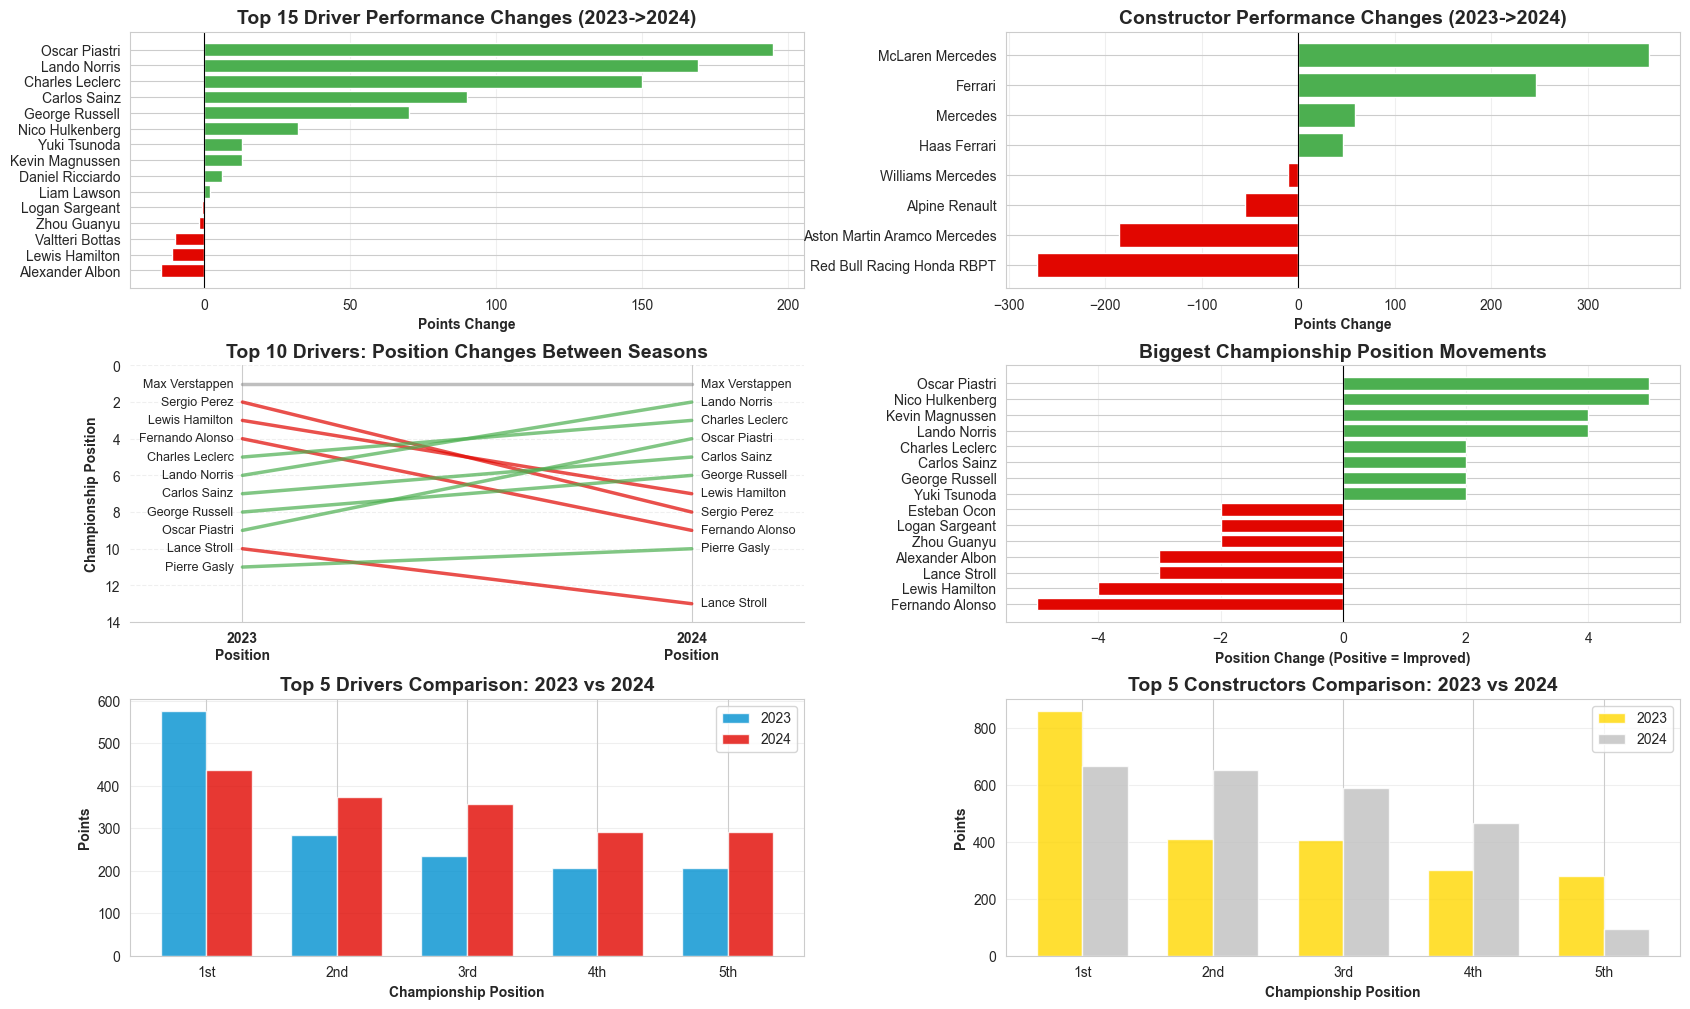


STATISTICAL SUMMARY:
   Drivers analyzed: 21
   Drivers improved: 10
   Drivers declined: 11
   Average points change: 9.0 pts
   Biggest improvement: Oscar Piastri (+195.0 pts)
   Biggest decline: Max Verstappen (-138.0 pts)

Exporting DataFrames to CSV...
  Exported 46 race results to f1_race_results.csv
  Exported 46 driver standings to f1_driver_standings.csv
  Exported 20 constructor standings to f1_constructor_standings.csv

Successfully exported 3 CSV file(s)

Browser closed successfully


In [16]:

# Global driver reference
driver = None

def cleanup():
    """Ensures driver is properly closed"""
    global driver
    if driver:
        try:
            driver.service.process.terminate()
            driver.quit()
        except:
            try:
                driver.service.process.kill()
            except:
                pass

def signal_handler(sig, frame):
    """Handles interruption (Ctrl+C)"""
    print("\nInterrupted! Cleaning up...")
    cleanup()
    sys.exit(0)

# Register cleanup handlers
atexit.register(cleanup)
signal.signal(signal.SIGINT, signal_handler)
signal.signal(signal.SIGTERM, signal_handler)


class F1DataAnalyzer:
    """
    Comprehensive F1 Data Scraper with Integrated Analysis Engine.
    
    This class combines web scraping with immediate data analysis,
    demonstrating a complete data science pipeline from collection to insights.
    """
    
    def __init__(self, headless=False, wait_time=15):
        """Initialize scraper and analysis components."""
        global driver
        
        self.base_url = "https://www.formula1.com"
        self.wait_time = wait_time
        
        # DataFrames to store scraped data
        self.df_races = pd.DataFrame()
        self.df_drivers = pd.DataFrame()
        self.df_constructors = pd.DataFrame()
        
        # Analysis results storage
        self.analysis_results = {}
        
        # Configure Chrome
        chrome_options = webdriver.ChromeOptions()
        if headless:
            chrome_options.add_argument('--headless=new')
        chrome_options.add_argument('--no-sandbox')
        chrome_options.add_argument('--disable-dev-shm-usage')
        chrome_options.add_argument('--disable-blink-features=AutomationControlled')
        chrome_options.add_argument('--window-size=1920,1080')
        chrome_options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36')
        
        # Initialize WebDriver
        service = Service(ChromeDriverManager().install())
        self.driver = webdriver.Chrome(service=service, options=chrome_options)
        driver = self.driver  # Store in global for cleanup
        self.wait = WebDriverWait(self.driver, wait_time)
        
        print("F1 Data Analyzer initialized successfully")
    
    def random_delay(self, min_seconds=2, max_seconds=4):
        """Add random delay."""
        time.sleep(random.uniform(min_seconds, max_seconds))
    
    def scroll_page(self):
        """Scroll to trigger lazy-loaded content."""
        self.driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1)
        self.driver.execute_script("window.scrollTo(0, 0);")
        time.sleep(0.5)
    
    def wait_for_table_load(self, timeout=20):
        """Wait for table to load."""
        try:
            WebDriverWait(self.driver, timeout).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "table tbody tr"))
            )
            time.sleep(2)
            return True
        except TimeoutException:
            return False
    
    def scrape_race_results(self, year=2023):
        """Scrape race results and store in DataFrame."""
        print(f"\nScraping {year} race results...")
        
        try:
            url = f"{self.base_url}/en/results/{year}/races"
            self.driver.get(url)
            self.random_delay(3, 5)
            self.scroll_page()
            
            if not self.wait_for_table_load():
                return pd.DataFrame()
            
            table = self.driver.find_element(By.CSS_SELECTOR, "table")
            rows = table.find_elements(By.TAG_NAME, "tr")
            
            data = []
            for idx, row in enumerate(rows[1:], 1):
                try:
                    cells = row.find_elements(By.TAG_NAME, "td")
                    if len(cells) >= 4:
                        cell_data = [cell.text.strip() for cell in cells]
                        
                        if cell_data[2]:  # Has winner
                            data.append({
                                'year': year,
                                'grand_prix': cell_data[0],
                                'date': cell_data[1],
                                'winner': cell_data[2],
                                'car': cell_data[3],
                                'laps': cell_data[4] if len(cell_data) > 4 else None,
                                'time': cell_data[5] if len(cell_data) > 5 else None
                            })
                except:
                    continue
            
            year_df = pd.DataFrame(data)
            self.df_races = pd.concat([self.df_races, year_df], ignore_index=True)
            print(f"Scraped {len(data)} races successfully")
            return year_df
            
        except Exception as e:
            print(f"Error scraping race results: {e}")
            return pd.DataFrame()
    
    def scrape_driver_standings(self, year=2023):
        """Scrape driver standings and store in DataFrame."""
        print(f"\nScraping {year} driver standings...")
        
        try:
            url = f"{self.base_url}/en/results/{year}/drivers"
            self.driver.get(url)
            self.random_delay(3, 5)
            self.scroll_page()
            
            if not self.wait_for_table_load():
                return pd.DataFrame()
            
            table = self.driver.find_element(By.CSS_SELECTOR, "table")
            rows = table.find_elements(By.TAG_NAME, "tr")
            
            data = []
            for row in rows[1:]:
                try:
                    cells = row.find_elements(By.TAG_NAME, "td")
                    if len(cells) >= 4:
                        cell_data = [cell.text.strip() for cell in cells]
                        
                        if cell_data[1]:  # Has driver name
                            data.append({
                                'year': year,
                                'position': int(cell_data[0]) if cell_data[0].isdigit() else 0,
                                'driver': cell_data[1],
                                'nationality': cell_data[2],
                                'car': cell_data[3],
                                'points': float(cell_data[4]) if len(cell_data) > 4 else 0.0
                            })
                except:
                    continue
            
            year_df = pd.DataFrame(data)
            self.df_drivers = pd.concat([self.df_drivers, year_df], ignore_index=True)
            print(f"Scraped {len(data)} driver records successfully")
            return year_df
            
        except Exception as e:
            print(f"Error scraping driver standings: {e}")
            return pd.DataFrame()
    
    def scrape_constructor_standings(self, year=2023):
        """Scrape constructor standings and store in DataFrame."""
        print(f"\nScraping {year} constructor standings...")
        
        try:
            url = f"{self.base_url}/en/results/{year}/team"
            self.driver.get(url)
            self.random_delay(3, 5)
            self.scroll_page()
            
            if not self.wait_for_table_load():
                return pd.DataFrame()
            
            table = self.driver.find_element(By.CSS_SELECTOR, "table")
            rows = table.find_elements(By.TAG_NAME, "tr")
            
            data = []
            for row in rows[1:]:
                try:
                    cells = row.find_elements(By.TAG_NAME, "td")
                    if len(cells) >= 2:
                        cell_data = [cell.text.strip() for cell in cells]
                        
                        if cell_data[1]:  # Has team name
                            data.append({
                                'year': year,
                                'position': int(cell_data[0]) if cell_data[0].isdigit() else 0,
                                'team': cell_data[1],
                                'points': float(cell_data[2]) if len(cell_data) > 2 else 0.0
                            })
                except:
                    continue
            
            year_df = pd.DataFrame(data)
            self.df_constructors = pd.concat([self.df_constructors, year_df], ignore_index=True)
            print(f"Scraped {len(data)} constructor records successfully")
            return year_df
            
        except Exception as e:
            print(f"Error scraping constructor standings: {e}")
            return pd.DataFrame()
    
    def scrape_2023_season(self):
        """Scrape complete 2023 season data."""
        print("\n" + "="*70)
        print("SCRAPING F1 2023 SEASON DATA")
        print("="*70)
        
        year = 2023
        print(f"\n--- Season {year} ---")
        self.scrape_race_results(year)
        self.random_delay(2, 3)
        self.scrape_driver_standings(year)
        self.random_delay(2, 3)
        self.scrape_constructor_standings(year)
        
        print(f"\nScraping complete!")
        print(f"   Races: {len(self.df_races)} records")
        print(f"   Drivers: {len(self.df_drivers)} records")
        print(f"   Constructors: {len(self.df_constructors)} records")
    
    def load_2024_data(self, races_file, drivers_file, constructors_file):
        """
        Load pre-existing 2024 data from CSV files.
        
        Args:
            races_file: Path to 2024 races CSV
            drivers_file: Path to 2024 drivers CSV
            constructors_file: Path to 2024 constructors CSV
        """
        print("\n" + "="*70)
        print("LOADING 2024 SEASON DATA FROM FILES")
        print("="*70)
        
        try:
            df_2024_races = pd.read_csv(races_file)
            df_2024_drivers = pd.read_csv(drivers_file)
            df_2024_constructors = pd.read_csv(constructors_file)
            
            # Ensure year column is set
            df_2024_races['year'] = 2024
            df_2024_drivers['year'] = 2024
            df_2024_constructors['year'] = 2024
            
            # Append to existing data
            self.df_races = pd.concat([self.df_races, df_2024_races], ignore_index=True)
            self.df_drivers = pd.concat([self.df_drivers, df_2024_drivers], ignore_index=True)
            self.df_constructors = pd.concat([self.df_constructors, df_2024_constructors], ignore_index=True)
            
            print(f"Loaded 2024 data successfully:")
            print(f"   Races: {len(df_2024_races)} records")
            print(f"   Drivers: {len(df_2024_drivers)} records")
            print(f"   Constructors: {len(df_2024_constructors)} records")
            
        except Exception as e:
            print(f"Error loading 2024 data: {e}")
            print("Please ensure the CSV files exist and are properly formatted")
    
    def analyze_year_over_year_comparison(self, year1=2023, year2=2024):
        """
        Compare two seasons head-to-head with advanced metrics.
        
        Args:
            year1: First year to compare
            year2: Second year to compare
        """
        print("\n" + "="*70)
        print(f"ANALYSIS: {year1} vs {year2} - Year-over-Year Comparison")
        print("="*70)
        
        # Filter data for both years
        df_y1_drivers = self.df_drivers[self.df_drivers['year'] == year1]
        df_y2_drivers = self.df_drivers[self.df_drivers['year'] == year2]
        df_y1_teams = self.df_constructors[self.df_constructors['year'] == year1]
        df_y2_teams = self.df_constructors[self.df_constructors['year'] == year2]
        
        # Driver comparison
        print(f"\nDRIVER PERFORMANCE CHANGES ({year1} -> {year2}):")
        
        # Find common drivers
        common_drivers = set(df_y1_drivers['driver']) & set(df_y2_drivers['driver'])
        
        driver_changes = []
        for driver_name in common_drivers:
            pts_y1 = df_y1_drivers[df_y1_drivers['driver'] == driver_name]['points'].values[0]
            pts_y2 = df_y2_drivers[df_y2_drivers['driver'] == driver_name]['points'].values[0]
            pos_y1 = df_y1_drivers[df_y1_drivers['driver'] == driver_name]['position'].values[0]
            pos_y2 = df_y2_drivers[df_y2_drivers['driver'] == driver_name]['position'].values[0]
            
            driver_changes.append({
                'driver': driver_name,
                f'{year1}_points': pts_y1,
                f'{year2}_points': pts_y2,
                'points_change': pts_y2 - pts_y1,
                'points_change_pct': ((pts_y2 - pts_y1) / pts_y1 * 100) if pts_y1 > 0 else 0,
                f'{year1}_position': pos_y1,
                f'{year2}_position': pos_y2,
                'position_change': pos_y1 - pos_y2  # Negative = improved
            })
        
        df_driver_changes = pd.DataFrame(driver_changes)
        df_driver_changes = df_driver_changes.sort_values('points_change', ascending=False)
        
        # Top improvers and decliners
        top_improvers = df_driver_changes.head(10)
        top_decliners = df_driver_changes.tail(10)
        
        print("\nTop 10 Most Improved Drivers:")
        print(top_improvers[['driver', f'{year1}_points', f'{year2}_points', 'points_change', 'position_change']].to_string(index=False))
        
        print("\nBottom 10 Drivers (Declined Performance):")
        print(top_decliners[['driver', f'{year1}_points', f'{year2}_points', 'points_change', 'position_change']].to_string(index=False))
        
        # Constructor comparison
        print(f"\nCONSTRUCTOR PERFORMANCE CHANGES ({year1} -> {year2}):")
        
        common_teams = set(df_y1_teams['team']) & set(df_y2_teams['team'])
        
        team_changes = []
        for team in common_teams:
            pts_y1 = df_y1_teams[df_y1_teams['team'] == team]['points'].values[0]
            pts_y2 = df_y2_teams[df_y2_teams['team'] == team]['points'].values[0]
            
            team_changes.append({
                'team': team,
                f'{year1}_points': pts_y1,
                f'{year2}_points': pts_y2,
                'points_change': pts_y2 - pts_y1,
                'points_change_pct': ((pts_y2 - pts_y1) / pts_y1 * 100) if pts_y1 > 0 else 0
            })
        
        df_team_changes = pd.DataFrame(team_changes)
        df_team_changes = df_team_changes.sort_values('points_change', ascending=False)
        
        print("\n" + df_team_changes[['team', f'{year1}_points', f'{year2}_points', 'points_change', 'points_change_pct']].to_string(index=False))
        
        # Visualization
        fig = plt.figure(figsize=(20, 12))
        gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
        
        # Plot 1: Driver Points Change (Top 15)
        ax1 = fig.add_subplot(gs[0, 0])
        top_15_changes = df_driver_changes.head(15)
        colors_drivers = ['#4CAF50' if x > 0 else '#E10600' for x in top_15_changes['points_change']]
        ax1.barh(range(len(top_15_changes)), top_15_changes['points_change'], color=colors_drivers)
        ax1.set_yticks(range(len(top_15_changes)))
        ax1.set_yticklabels(top_15_changes['driver'])
        ax1.set_xlabel('Points Change', fontweight='bold')
        ax1.set_title(f'Top 15 Driver Performance Changes ({year1}->{year2})', fontsize=14, fontweight='bold')
        ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
        ax1.invert_yaxis()
        ax1.grid(axis='x', alpha=0.3)
        
        # Plot 2: Constructor Points Change
        ax2 = fig.add_subplot(gs[0, 1])
        colors_teams = ['#4CAF50' if x > 0 else '#E10600' for x in df_team_changes['points_change']]
        ax2.barh(range(len(df_team_changes)), df_team_changes['points_change'], color=colors_teams)
        ax2.set_yticks(range(len(df_team_changes)))
        ax2.set_yticklabels(df_team_changes['team'])
        ax2.set_xlabel('Points Change', fontweight='bold')
        ax2.set_title(f'Constructor Performance Changes ({year1}->{year2})', fontsize=14, fontweight='bold')
        ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
        ax2.invert_yaxis()
        ax2.grid(axis='x', alpha=0.3)
        
 # Plot 3: Championship Position Flow (Sankey-style visualization)
        ax3 = fig.add_subplot(gs[1, 0])
        
        # Get top 10 drivers from each year by position
        top_drivers_both_years = set(
            list(df_y1_drivers.nsmallest(10, 'position')['driver']) +
            list(df_y2_drivers.nsmallest(10, 'position')['driver'])
        )
        
        # Filter to drivers in top 10 of either year
        flow_data = df_driver_changes[df_driver_changes['driver'].isin(top_drivers_both_years)].copy()
        flow_data = flow_data.sort_values(f'{year1}_position')
        
        # Create the flow visualization
        for idx, row in flow_data.iterrows():
            pos_y1 = row[f'{year1}_position']
            pos_y2 = row[f'{year2}_position']
            
            # Color based on improvement or decline
            if pos_y1 > pos_y2:  # Improved (moved up)
                color = '#4CAF50'
                alpha = 0.7
            elif pos_y1 < pos_y2:  # Declined (moved down)
                color = '#E10600'
                alpha = 0.7
            else:  # Stayed same
                color = '#808080'
                alpha = 0.5
            
            # Draw connecting line
            ax3.plot([0, 1], [pos_y1, pos_y2], color=color, alpha=alpha, linewidth=2.5)
            
            # Add driver labels
            ax3.text(-0.02, pos_y1, row['driver'], ha='right', va='center', fontsize=9)
            ax3.text(1.02, pos_y2, row['driver'], ha='left', va='center', fontsize=9)
        
        # Formatting
        ax3.set_xlim(-0.25, 1.25)
        ax3.set_ylim(max(flow_data[f'{year1}_position'].max(), flow_data[f'{year2}_position'].max()) + 1, 0)
        ax3.set_xticks([0, 1])
        ax3.set_xticklabels([f'{year1}\nPosition', f'{year2}\nPosition'], fontweight='bold')
        ax3.set_ylabel('Championship Position', fontweight='bold')
        ax3.set_title('Top 10 Drivers: Position Changes Between Seasons', fontsize=14, fontweight='bold')
        ax3.grid(axis='y', alpha=0.3, linestyle='--')
        ax3.spines['top'].set_visible(False)
        ax3.spines['right'].set_visible(False)
        ax3.spines['left'].set_visible(False)
        
        
        # Plot 4: Position Changes
        ax4 = fig.add_subplot(gs[1, 1])
        sig_position_changes = df_driver_changes[df_driver_changes['position_change'].abs() >= 2].copy()
        sig_position_changes = sig_position_changes.sort_values('position_change', ascending=False).head(15)
        
        colors_pos = ['#4CAF50' if x > 0 else '#E10600' for x in sig_position_changes['position_change']]
        ax4.barh(range(len(sig_position_changes)), sig_position_changes['position_change'], color=colors_pos)
        ax4.set_yticks(range(len(sig_position_changes)))
        ax4.set_yticklabels(sig_position_changes['driver'])
        ax4.set_xlabel('Position Change (Positive = Improved)', fontweight='bold')
        ax4.set_title('Biggest Championship Position Movements', fontsize=14, fontweight='bold')
        ax4.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
        ax4.invert_yaxis()
        ax4.grid(axis='x', alpha=0.3)
        
        # Plot 5: Champion Comparison
        ax5 = fig.add_subplot(gs[2, 0])
        top_5_y1 = df_y1_drivers.nsmallest(5, 'position')
        top_5_y2 = df_y2_drivers.nsmallest(5, 'position')
        
        x_pos = np.arange(5)
        width = 0.35
        
        ax5.bar(x_pos - width/2, top_5_y1['points'].values, width, label=str(year1), color='#0090D0', alpha=0.8)
        ax5.bar(x_pos + width/2, top_5_y2['points'].values, width, label=str(year2), color='#E10600', alpha=0.8)
        
        ax5.set_xlabel('Championship Position', fontweight='bold')
        ax5.set_ylabel('Points', fontweight='bold')
        ax5.set_title(f'Top 5 Drivers Comparison: {year1} vs {year2}', fontsize=14, fontweight='bold')
        ax5.set_xticks(x_pos)
        ax5.set_xticklabels(['1st', '2nd', '3rd', '4th', '5th'])
        ax5.legend()
        ax5.grid(axis='y', alpha=0.3)
        
        # Plot 6: Constructor Comparison (Top 5)
        ax6 = fig.add_subplot(gs[2, 1])
        top_5_teams_y1 = df_y1_teams.nsmallest(5, 'position')
        top_5_teams_y2 = df_y2_teams.nsmallest(5, 'position')
        
        x_pos_teams = np.arange(5)
        
        ax6.bar(x_pos_teams - width/2, top_5_teams_y1['points'].values, width, 
               label=str(year1), color='#FFD700', alpha=0.8)
        ax6.bar(x_pos_teams + width/2, top_5_teams_y2['points'].values, width, 
               label=str(year2), color='#C0C0C0', alpha=0.8)
        
        ax6.set_xlabel('Championship Position', fontweight='bold')
        ax6.set_ylabel('Points', fontweight='bold')
        ax6.set_title(f'Top 5 Constructors Comparison: {year1} vs {year2}', fontsize=14, fontweight='bold')
        ax6.set_xticks(x_pos_teams)
        ax6.set_xticklabels(['1st', '2nd', '3rd', '4th', '5th'])
        ax6.legend()
        ax6.grid(axis='y', alpha=0.3)
        
        plt.savefig(f'year_comparison_{year1}_vs_{year2}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Statistical summary
        print(f"\nSTATISTICAL SUMMARY:")
        print(f"   Drivers analyzed: {len(common_drivers)}")
        print(f"   Drivers improved: {len(df_driver_changes[df_driver_changes['points_change'] > 0])}")
        print(f"   Drivers declined: {len(df_driver_changes[df_driver_changes['points_change'] < 0])}")
        print(f"   Average points change: {df_driver_changes['points_change'].mean():.1f} pts")
        print(f"   Biggest improvement: {df_driver_changes.iloc[0]['driver']} (+{df_driver_changes.iloc[0]['points_change']:.1f} pts)")
        print(f"   Biggest decline: {df_driver_changes.iloc[-1]['driver']} ({df_driver_changes.iloc[-1]['points_change']:.1f} pts)")
        
        self.analysis_results['year_comparison'] = {
            'driver_changes': df_driver_changes,
            'team_changes': df_team_changes
        }
        
        return df_driver_changes, df_team_changes
    
    def export_to_csv(self, suffix=''):
        """
        Export DataFrames to CSV with error handling.
        
        Args:
            suffix: Optional suffix to add to filenames (e.g., timestamp)
        """
        print("\nExporting DataFrames to CSV...")
        
        if suffix:
            suffix = f"_{suffix}"
        
        csv_files = [
            (self.df_races, f'f1_race_results{suffix}.csv', 'race results'),
            (self.df_drivers, f'f1_driver_standings{suffix}.csv', 'driver standings'),
            (self.df_constructors, f'f1_constructor_standings{suffix}.csv', 'constructor standings')
        ]
        
        exported = []
        failed = []
        
        for df, filename, name in csv_files:
            if not df.empty:
                try:
                    df.to_csv(filename, index=False)
                    print(f"  Exported {len(df)} {name} to {filename}")
                    exported.append(filename)
                except PermissionError:
                    print(f"  Warning: Could not export {filename} - file is open in another program")
                    failed.append(filename)
                except Exception as e:
                    print(f"  Error exporting {filename}: {e}")
                    failed.append(filename)
        
        if exported:
            print(f"\nSuccessfully exported {len(exported)} CSV file(s)")
        if failed:
            print(f"\nFailed to export {len(failed)} file(s)")
        
        return exported, failed
    
    def run_complete_analysis(self, races_2024_csv, drivers_2024_csv, constructors_2024_csv, export_csv=True):
        
        # Step 1: Scrape 2023 data
        self.scrape_2023_season()
        
        # Step 2: Load 2024 data from existing files
        self.load_2024_data(races_2024_csv, drivers_2024_csv, constructors_2024_csv)
        
        # Step 3: Run year-over-year analysis
        print("\n" + "="*70)
        print("RUNNING COMPARATIVE ANALYSIS...")
        print("="*70)
        
        self.analyze_year_over_year_comparison(year1=2023, year2=2024)
        
        # Step 4: Export DataFrames to CSV (optional)
        if export_csv:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            exported, failed = self.export_to_csv()
            
            # If export failed, offer timestamped version
            if failed:
                print(f"\nAlternative: Exporting with timestamp...")
                self.export_to_csv(suffix=timestamp)
        
        return {
            'races': self.df_races,
            'drivers': self.df_drivers,
            'constructors': self.df_constructors,
            'analysis': self.analysis_results
        }
    
    def close(self):
        """Close browser."""
        cleanup()
        print("\nBrowser closed successfully")


if __name__ == "__main__":
    print("\n" + "="*70)
    print("F1 DATA ANALYSIS: 2023 vs 2024 COMPARISON")
    print("="*70)
    
    try:
        # Initialize analyzer
        analyzer = F1DataAnalyzer(headless=False, wait_time=15)
        
        # Run complete analysis
        # Replace these paths with your actual 2024 CSV file paths
        results = analyzer.run_complete_analysis(
            races_2024_csv='f1_race_results_2024.csv',
            drivers_2024_csv='f1_driver_standings_2024.csv',
            constructors_2024_csv='f1_constructor_standings_2024.csv',
            export_csv=True
        )
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        
    finally:
        analyzer.close()

In [21]:
def clear_driver_memory(close_figures=True):
    """
    Cleanly shut down Selenium drivers and release references to save memory.
    """
    global driver, wait, analyzer
    try:
        if 'analyzer' in globals() and analyzer is not None:
            try:
                analyzer.close()
            except Exception as e:
                print(f"Analyzer close error: {e}")
            finally:
                try:
                    analyzer.driver = None
                except Exception:
                    pass
                analyzer = None
        else:
            # Fallback to existing cleanup() if available
            try:
                cleanup()
            except Exception:
                # Directly try to close driver if still present
                try:
                    if 'driver' in globals() and driver is not None:
                        try:
                            driver.quit()
                        except Exception:
                            pass
                finally:
                    driver = None
    except Exception as e:
        print(f"Cleanup error: {e}")

    # Drop references to wait/driver
    try:
        wait = None
    except Exception:
        pass
    try:
        driver = None
    except Exception:
        pass

    # Force GC to reclaim memory
    collected = gc.collect()
    print(f"✓ Cleared Selenium drivers and references. GC collected: {collected} objects.")

# Execute cleanup now
clear_driver_memory()

✓ Cleared Selenium drivers and references. GC collected: 0 objects.
